# Automated Hip Prosthesis Surveillance Registry Project

# Author: John Radin, Health Research Specialist at VA Research
# Release Date: 07/22/2020
# Contact: john.radin@va.gov

In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import itertools
import sqlalchemy as sql
import pyodbc
from datetime import datetime, timedelta, date
import time
import glob
import os
from fuzzywuzzy import fuzz, process
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, NullFormatter
import seaborn as sns
from lifelines import KaplanMeierFitter 
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import survival_table_from_events
import lifelines

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

C:\Users\vhapalradinj\AppData\Local\Continuum\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
%%time

# create the main denormalized dataset consisting of the total hip arthoplasty surgical procedures, prosthetic details, and report texts

db_server = 'SERVER_NAME'
db_name = 'DB_NAME'
driver = 'SQl Server'
engine = sql.create_engine('mssql+pyodbc://{}/{}?driver={}'.format(db_server, db_name, driver))

db_surgery_query = '''SELECT cc.PatientICN,
                             spat.PatientSSN,
                             surgpost.PatientSID,
                             surgpost.SurgerySID,
                             surgpost.Sta3n,
                             surgpost.SurgeryDateTime, 
                             icd9proc.ICD9ProcedureCode,
                             icd10proc.ICD10ProcedureCode,
                             cptdes.CPTCode,
                             imppros.ProsthesisVendor, 
                             imppros.ProsthesisModel, 
                             imppros.ProsthesisSize,
                             imppros.LotSerialNumber,
                             imppros.LotNumber,
                             imppros.SerialNumber,
                             surgpre.PrincipalPreOpDiagnosisText,
                             surgpre.PrincipalDiagnosisText,
                             surgpre.PrincipalPostOpDiagnosisText,
                             surgpre.ScheduledProcedure, 
                             tiu.ReportText as operative_report_text,
                             tiu2.ReportText as nurse_intraoperative_report_text
                      FROM [DB_NAME].[Src].[Surg_SurgeryPOST] as surgpost
                      LEFT JOIN [DB_NAME].[Src].[Surg_SurgeryPRE] as surgpre
                           ON surgpre.SurgerySID = surgpost.SurgerySID
                      LEFT JOIN [DB_NAME].[Src].[SPatient_ImplantedProsthesis] as imppros 
                           ON imppros.SurgerySID = surgpost.SurgerySID 
                      LEFT JOIN [DB_NAME].[Src].[Surg_SurgeryProcedureDiagnosisCode] as surgproc
                           ON surgproc.SurgerySID = surgpost.SurgerySID
                      LEFT JOIN [DB_NAME].[Dim].[ICD9Procedure] as icd9proc 
                           ON icd9proc.ICD9ProcedureSID = surgproc.PrincipalPostOpICD9SID
                      LEFT JOIN [DB_NAME].[Dim].[ICD10Procedure] as icd10proc 
                           ON icd10proc.ICD10ProcedureSID = surgproc.PrincipalPostOpICD10SID
                      LEFT JOIN [DB_NAME].[Dim].[CPT] as cptdes 
                           ON cptdes.CPTSID = surgproc.PrincipalCPTSID
                      LEFT JOIN [DB_NAME].[Src].[TIU_TIUDocument_8925] as tiu 
                           ON tiu.TIUDocumentSID = surgpost.OperativeTIUDocumentSID
                      LEFT JOIN [DB_NAME].[Src].[TIU_TIUDocument_8925] as tiu2 
                           ON tiu2.TIUDocumentSID = surgpost.NurseIntraOperativeTIUDocumentSID     
                      LEFT JOIN [DB_NAME].[Src].[CohortCrosswalk] as cc 
                           ON cc.PatientSID = surgpost.PatientSID
                      LEFT JOIN [DB_NAME].[Src].[SPatient_SPatient] as spat
                           ON spat.PatientSID = surgpost.PatientSID
                      WHERE (surgpost.SurgeryDateTime >= CAST('2000-01-01' as datetime2(0)) AND 
                             surgpost.SurgeryDateTime <  CAST('2018-01-01' as datetime2(0))) AND
                            (tiu.EntryDateTime >= CAST('2000-01-01' as datetime2(0)) AND
                             tiu.EntryDateTime < CAST('2018-01-01' as datetime2(0)) OR 
                             tiu.EntryDateTime IS NULL) AND 
                            (tiu2.EntryDateTime >= CAST('2000-01-01' as datetime2(0)) AND
                             tiu2.EntryDateTime < CAST('2018-01-01' as datetime2(0)) OR
                             tiu2.EntryDateTime IS NULL) AND
                            (cptdes.CPTCode IN ('27090','27091','27130','27132','27134','27137','27138')) '''

df_surgery = pd.read_sql_query(db_surgery_query, engine)
df_surgery.to_parquet('PATH/all_surgery_dtls_plus_notes_2000_01_01_2018_01_01.parquet', engine='pyarrow', compression='gzip')

Wall time: 5min 52s


In [3]:
%%time

# get date of death for right censoring

db_server = 'SERVER_NAME'
db_name = 'DB_NAME'
driver = 'SQl Server'
engine = sql.create_engine('mssql+pyodbc://{}/{}?driver={}'.format(db_server, db_name, driver))

db_dod_query = '''SELECT MIN(hc.PatientICN) as PatientICN,
                         MAX(sp.DeathDateTime) as DeathDateTime
                  FROM [DB_NAME].[Src].[SPatient_SPatient] as sp
                  INNER JOIN [DB_NAME].[Dflt].[Hip_Patients_Revised] as hc
                          ON sp.PatientICN = hc.PatientICN
                  GROUP BY hc.PatientICN'''

df_dod = pd.read_sql_query(db_dod_query, engine)
df_dod.to_parquet('PATH/hip_cohort_censoring_dod.parquet', engine='pyarrow', compression='gzip')

Wall time: 4.2 s


In [4]:
%%time

db_server = 'SERVER_NAME'
db_name = 'DB_NAME'
driver = 'SQl Server'
engine = sql.create_engine('mssql+pyodbc://{}/{}?driver={}'.format(db_server, db_name, driver))

db_outpat_visits_query = '''SELECT MIN(hc.PatientICN) as PatientICN,
                                   MAX(ovd.VisitDateTime) as outpat_visit_dt 
                            FROM [DB_NAME].[Src].[Outpat_VDiagnosis] as ovd
                            INNER JOIN [DB_NAME].[Src].[SPatient_SPatient] as pat
                                    ON ovd.PatientSID = pat.PatientSID
                            INNER JOIN [DB_NAME].[Dflt].[Hip_Patients_Revised] as hc
                                    ON pat.PatientICN = hc.PatientICN
                            GROUP BY hc.PatientICN'''

df_outpat_visits = pd.read_sql_query(db_outpat_visits_query, engine)
df_outpat_visits.rename({'outpat_visit_dt':'max_va_dt'}, axis='columns', inplace=True)

Wall time: 1min 56s


In [5]:
%%time

db_server = 'SERVER_NAME'
db_name = 'DB_NAME'
driver = 'SQl Server'
engine = sql.create_engine('mssql+pyodbc://{}/{}?driver={}'.format(db_server, db_name, driver))

db_inpat_visits_query = '''SELECT MIN(hc.PatientICN) as PatientICN,
                                  MAX(ip.AdmitDateTime) as inpat_visit_dt 
                           FROM [DB_NAME].[Src].[Inpat_Inpatient] as ip
                           INNER JOIN [DB_NAME].[Src].[SPatient_SPatient] as pat
                                   ON ip.PatientSID = pat.PatientSID
                           INNER JOIN [DB_NAME].[Dflt].[Hip_Patients_Revised] as hc
                                   ON pat.PatientICN = hc.PatientICN
                           GROUP BY hc.PatientICN'''
                           
df_inpat_visits = pd.read_sql_query(db_inpat_visits_query, engine)
df_inpat_visits.rename({'inpat_visit_dt':'max_va_dt'}, axis='columns', inplace=True)

Wall time: 15 s


In [6]:
%%time

db_server = 'SERVER_NAME'
db_name = 'DB_NAME'
driver = 'SQl Server'
engine = sql.create_engine('mssql+pyodbc://{}/{}?driver={}'.format(db_server, db_name, driver))

db_surgery_query = '''SELECT MIN(hc.PatientICN) as PatientICN,
                             MAX(surgpost.SurgeryDateTime) as surgery_dt 
                      FROM [DB_NAME].[Src].[Surg_SurgeryPOST] as surgpost
                      INNER JOIN [DB_NAME].[Src].[SPatient_SPatient] as pat
                            ON surgpost.PatientSID = pat.PatientSID
                      INNER JOIN [DB_NAME].[Dflt].[Hip_Patients_Revised] as hc
                            ON pat.PatientICN = hc.PatientICN
                      GROUP BY hc.PatientICN'''
                           
df_surgery = pd.read_sql_query(db_surgery_query, engine)
df_surgery.rename({'surgery_dt':'max_va_dt'}, axis='columns', inplace=True)

Wall time: 13.2 s


In [7]:
%%time

# get max va service date for right censoring

df_max_va_dt = pd.concat([df_inpat_visits, df_outpat_visits, df_surgery], ignore_index=True)
df_max_va_dt = df_max_va_dt.groupby(['PatientICN'], as_index=False)['max_va_dt'].max()

#fix the issue with the future dates by setting the max_va_dt to day this is run if showing a future date

today = time.strftime('%Y-%m-%d')
df_max_va_dt['max_va_dt'] = np.where((df_max_va_dt['max_va_dt'] > today), today, df_max_va_dt['max_va_dt'])

df_max_va_dt.to_parquet('PATH/hip_cohort_censoring_max_va_dt.parquet', engine='pyarrow', compression='gzip')

Wall time: 1min 29s


FDA GUDID Database Delimited Format Download: https://accessgudid.nlm.nih.gov/download/delimited 

In [33]:
%%time

# importing all datasets

df_gmdn = pd.read_csv('DATA\AccessGUDID_Delimited_Full_Release_20180801\gmdnTerms.txt', sep='|', header=0, index_col=False, low_memory=False)
df_gmdn['PrimaryDI'] = df_gmdn['PrimaryDI'].astype(str)
df_gmdn.drop_duplicates(['PrimaryDI'], keep='first', inplace=True)
df_gmdn.drop(['gmdnPTDefinition'], axis=1, inplace=True)
df_gmdn.reset_index(drop=True, inplace=True)

df_product_code = pd.read_csv('DATA\AccessGUDID_Delimited_Full_Release_20180801\productCodes.txt', sep='|', header=0, index_col=False, low_memory=False)
df_product_code['PrimaryDI'] = df_product_code['PrimaryDI'].astype(str)
df_product_code.drop_duplicates(['PrimaryDI'], keep='first', inplace=True)
df_product_code.reset_index(drop=True, inplace=True)

df_fda_prosthetic_part_lookup = pd.read_csv('DATA\AccessGUDID_Delimited_Full_Release_20180801\device.txt', sep='|', header=0, index_col=False, low_memory=False)
# clean model number field of extraneous non-numeric characters and whitespace
df_fda_prosthetic_part_lookup['versionModelNumber'] = df_fda_prosthetic_part_lookup['versionModelNumber'].astype(str).str.replace(r'\W+|(?<!\d)[^\W\d_](?!\S*\d)', '').replace(r'\s+', ' ', regex=True)

# supplementary lookup to augment GUDID
df_recalled_prosthetic_part_lookup = pd.read_csv('DATA\recalled_hip_device_lookup.csv', sep=',')  

df_combined_prosthetic_part_lookup = pd.concat([df_fda_prosthetic_part_lookup, df_recalled_prosthetic_part_lookup], axis=0, ignore_index=False, sort=False)
df_combined_prosthetic_part_lookup.reset_index(drop=True, inplace=True)

df_surgery = pd.read_parquet('DATA\all_surgery_dtls_plus_notes_2000_01_01_2018_01_01.parquet', engine='pyarrow')
# clean model number field of extraneous non-numeric characters and whitespace
df_surgery['ProsthesisModelStripped'] = df_surgery['ProsthesisModel'].astype(str).str.replace(r'\W+|(?<!\d)[^\W\d_](?!\S*\d)', '').str.replace(r'ref|cat','', case=False).replace(r'\s+', ' ', regex=True)

df_dod = pd.read_parquet('DATA\hip_cohort_censoring_dod.parquet', engine='pyarrow')

df_max_va_dt = pd.read_parquet('DATA\hip_cohort_censoring_max_va_dt.parquet', engine='pyarrow')
df_max_va_dt.reset_index(drop=True, inplace=True)

Wall time: 2min 34s


In [34]:
%%time

df_surgery_test = df_surgery[['PatientICN','SurgerySID','SurgeryDateTime','ProsthesisVendor','ProsthesisModel',
                              'ProsthesisModelStripped','ICD9ProcedureCode','ICD10ProcedureCode',
                              'CPTCode','ScheduledProcedure','PrincipalPostOpDiagnosisText']] #,
                              #'operative_report_text','nurse_intraoperative_report_text']]
df_surgery_test['ProsthesisModelStripped'] = df_surgery_test['ProsthesisModelStripped'].astype(str)
df_surgery_test['key'] = df_surgery_test['ProsthesisModelStripped'].astype(str)

# part lookup refinement with vender shortlist and derived 5 minimum digits model number criteria

vendor_pattern = 'zimmer|stryker|depuy|smith & nephew|smith&nephew|s&n|smith and nephew|stingray|biomet|howmedica|exactech|osteonics|j&j|johnson & johnson|wright medical'

df_lookup = df_combined_prosthetic_part_lookup[((df_combined_prosthetic_part_lookup['brandName'].astype(str).str.contains(vendor_pattern, case=False, regex=True)) |
                                                (df_combined_prosthetic_part_lookup['companyName'].astype(str).str.contains(vendor_pattern, case=False, regex=True)) |
                                                (df_combined_prosthetic_part_lookup['ProsthesisVendorName'].astype(str).str.contains(vendor_pattern, case=False, regex=True))) &
                                               (df_combined_prosthetic_part_lookup['versionModelNumber'].str.len() > 5)]
df_lookup.reset_index(drop=True, inplace=True)

df_lookup['key'] = df_lookup['versionModelNumber'].astype(str)

df_temp_1 = pd.merge(df_surgery_test, df_lookup, on='key', how='left')
#del df_surgery_test, df_lookup
df_temp_2 = pd.merge(df_temp_1, df_product_code, on='PrimaryDI', how='left')
#del df_temp_1, df_product_code
df_temp_3 = pd.merge(df_temp_2, df_gmdn, on='PrimaryDI', how='left')
#del df_temp_2, df_gmdn
df_temp_4 = pd.merge(df_temp_3, df_dod, on='PatientICN', how='left')
#del df_temp_3, df_dod
df_surgery_device_dtls = pd.merge(df_temp_4, df_max_va_dt, on='PatientICN', how='left')
#del df_temp_4, df_max_va_dt
df_surgery_device_dtls.reset_index(drop=True, inplace=True)

# these extra steps bring over values for the recalled parts not in GUDID

df_surgery_device_dtls['companyName'] = np.where((df_surgery_device_dtls['companyName'].isnull()), df_surgery_device_dtls['ProsthesisVendorName'], df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where((df_surgery_device_dtls['brandName'].isnull()), df_surgery_device_dtls['ProsthesisVendorName'], df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where((df_surgery_device_dtls['gmdnPTName'].isnull()), df_surgery_device_dtls['deviceDescription'], df_surgery_device_dtls['gmdnPTName'])

Wall time: 1min 5s


In [35]:
%%time

# create laterality variable

df_surgery_device_dtls['ScheduledProcedure'] = df_surgery_device_dtls['ScheduledProcedure'].str.lower()
df_surgery_device_dtls['PrincipalPostOpDiagnosisText'] = df_surgery_device_dtls['PrincipalPostOpDiagnosisText'].str.lower()

right_laterality_mask = ((df_surgery_device_dtls['ScheduledProcedure'].str.contains('right')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.contains('rigth')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.contains('rihgt')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.contains('righ')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.contains('rthr ')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.contains('rtha')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.contains('r.tha')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.contains('r.thr')) |
                         (df_surgery_device_dtls['PrincipalPostOpDiagnosisText'].str.contains('right')) |
                         (df_surgery_device_dtls['PrincipalPostOpDiagnosisText'].str.endswith('rt')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.startswith('rt ')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.startswith('rt.')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.startswith('r/')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.startswith('r. ')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.startswith('r ')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.endswith('-r')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.endswith('rt')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.contains(' r ')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.contains(' r. ')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.contains(' rt ')) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.contains(')r ', regex=False)) |
                         (df_surgery_device_dtls['ScheduledProcedure'].str.contains('(r)', regex=False)) |
                         ((df_surgery_device_dtls['PrincipalPostOpDiagnosisText'].str.contains('right')) & 
                          (df_surgery_device_dtls['PrincipalPostOpDiagnosisText'].str.contains('left') == False) & 
                          (df_surgery_device_dtls['ScheduledProcedure'].str.contains('bilat'))))

left_laterality_mask = ((df_surgery_device_dtls['ScheduledProcedure'].str.contains('left')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains('lef')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains('lft')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains('lth')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains('lf')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains('lthr')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains('ltha')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains('ltka')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains('l.tha')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains('l/tha')) |
                        (df_surgery_device_dtls['PrincipalPostOpDiagnosisText'].str.contains('left')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.startswith('lt ')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.startswith('lt.')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.startswith('l ')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.startswith('l. ')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.startswith('l.')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.endswith('-l')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.endswith('lt')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.endswith(' l')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains(' l ')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains(' l. ')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains('l. ')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains(')l ', regex=False)) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains(')l. ', regex=False)) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains(' lt ')) |
                        (df_surgery_device_dtls['ScheduledProcedure'].str.contains('(l)', regex=False)) |
                        ((df_surgery_device_dtls['PrincipalPostOpDiagnosisText'].str.contains('left'))  &
                         (df_surgery_device_dtls['PrincipalPostOpDiagnosisText'].str.contains('right') == False) &
                         (df_surgery_device_dtls['ScheduledProcedure'].str.contains('bilat'))))

bilaterality_mask = (((df_surgery_device_dtls['ScheduledProcedure'].str.contains('bilat')) |
                     ((df_surgery_device_dtls['ScheduledProcedure'].str.contains('bilat')) &
                      (df_surgery_device_dtls['ScheduledProcedure'].str.contains('left')) &
                      (df_surgery_device_dtls['ScheduledProcedure'].str.contains('right')))) &
                    ((df_surgery_device_dtls['PrincipalPostOpDiagnosisText'].str.contains('bilat')) |
                     (df_surgery_device_dtls['PrincipalPostOpDiagnosisText'].str.contains('bi.')) |
                     (df_surgery_device_dtls['PrincipalPostOpDiagnosisText'].str.contains('both')) |
                    ((df_surgery_device_dtls['PrincipalPostOpDiagnosisText'].str.contains('left')) & (df_surgery_device_dtls['PrincipalPostOpDiagnosisText'].str.contains('right')))))

laterality_criteria = [bilaterality_mask, right_laterality_mask, left_laterality_mask] 
laterality_values = ['bilateral','right','left'] 
df_surgery_device_dtls['laterality'] = np.select(laterality_criteria, laterality_values, default=np.nan)

Wall time: 17.5 s


In [37]:
%%time

# create part type variable

part_criteria = [((df_surgery_device_dtls['gmdnPTName'].str.contains('acetabular component|acetabular shell|acetabulum|socket|shell', case=False, na=False)) &
                 ~(df_surgery_device_dtls['gmdnPTName'].str.contains('acetabulum prosthesis hole plug', case=False, na=False))),
                 df_surgery_device_dtls['gmdnPTName'].str.contains('acetabular bearing surface|liner|polyethylene|bearing surface', case=False, na=False),  
                 df_surgery_device_dtls['gmdnPTName'].str.contains('femoral stem|femoral sleeve|sleeve femoral|femoral component|femur', case=False, na=False),
                 ((df_surgery_device_dtls['gmdnPTName'].str.contains('femoral head|hip ball|ball|head', case=False, na=False)) &
                 ~(df_surgery_device_dtls['gmdnPTName'].str.contains('femoral head/stem prosthesis adaptor', case=False, na=False))),  
                 df_surgery_device_dtls['gmdnPTName'].str.contains('screw', case=False, na=False),
                 df_surgery_device_dtls['gmdnPTName'].str.contains('cement', case=False, na=False),
                 df_surgery_device_dtls['gmdnPTName'].str.contains('bone wire', case=False, na=False)]  
                
part_labels = ['shell',
               'liner',
               'stem',
               'ball',
               'screw',
               'cement',
               'bone wire']   

df_surgery_device_dtls['device_type_label'] = np.select(part_criteria, part_labels, default=np.nan)

Wall time: 7.94 s


In [38]:
%%time

# create part material variable

material_criteria = [df_surgery_device_dtls['gmdnPTName'].str.contains('metal|metallic', case=False, na=False),
                     df_surgery_device_dtls['gmdnPTName'].str.contains('ceramic', case=False, na=False),
                     df_surgery_device_dtls['gmdnPTName'].str.contains('polyethylene', case=False, na=False)]

material_labels = ['metallic',
                   'ceramic',
                   'polyethylene']

df_surgery_device_dtls['device_material_label'] = np.select(material_criteria, material_labels, default=np.nan)

Wall time: 1.56 s


In [39]:
%%time

# create primary or revision indicator variable

primary_revision_criteria = [df_surgery_device_dtls['CPTCode'].astype(str).str.contains('27130|27132', case=False, na=False),
                             df_surgery_device_dtls['CPTCode'].astype(str).str.contains('27090|27091|27134|27137|27138', case=False, na=False)]

primary_revision_labels = ['primary',
                           'revision']

df_surgery_device_dtls['primary_revision_ind'] = np.select(primary_revision_criteria, primary_revision_labels, default=np.nan)

Wall time: 859 ms


In [40]:
%%time

# create year range bin variable

df_surgery_device_dtls['year'] = pd.to_datetime(df_surgery_device_dtls['SurgeryDateTime']).dt.year
year_bins = [2000,2005,2010,2015,2020]
year_bin_labels = ['2000-2004','2005-2009','2010-2014','2015-Present']
df_surgery_device_dtls['year_bins'] = pd.cut(df_surgery_device_dtls['year'], bins=year_bins, labels=year_bin_labels, right=False)

Wall time: 469 ms


In [44]:
%%time

# drop any duplicate records

df_surgery_device_dtls.drop_duplicates(['PatientICN','SurgeryDateTime','ProsthesisModelStripped','laterality'], keep='first', inplace=True)
df_surgery_device_dtls.reset_index(drop=True, inplace=True)

Wall time: 906 ms


In [46]:
%%time

# supplement some extra missing part details

# stems

zimmer_kinectiv_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('7713', case=False)) &
                        (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                        (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_kinectiv_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_kinectiv_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_kinectiv_mask, 'kinectiv stem', df_surgery_device_dtls['gmdnPTName'])

zimmer_kinectiv_coated_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('657713', case=False)) &
                               (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                               (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_kinectiv_coated_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_kinectiv_coated_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_kinectiv_coated_mask, 'kinectiv ha coated stem', df_surgery_device_dtls['gmdnPTName'])

zimmer_ml_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('7711', case=False)) &
                  (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                  (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_ml_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_ml_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_ml_mask, 'm/l taper stem', df_surgery_device_dtls['gmdnPTName'])

zimmer_ml_coated_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('657711', case=False)) &
                         (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                         (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_ml_coated_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_ml_coated_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_ml_coated_mask, 'm/l taper ha coated stem', df_surgery_device_dtls['gmdnPTName'])

zimmer_trab_met_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('7864', case=False)) &
                        (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                        (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_trab_met_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_trab_met_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_trab_met_mask, 'trabecular metal stem', df_surgery_device_dtls['gmdnPTName'])

zimmer_fib_met_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('7862', case=False)) &
                       (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                       (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_fib_met_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_fib_met_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_fib_met_mask, 'fiber metal taper stem', df_surgery_device_dtls['gmdnPTName'])

zimmer_fib_met_mid_collared_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('7841', case=False)) &
                                    (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                                    (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_fib_met_mid_collared_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_fib_met_mid_collared_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_fib_met_mid_collared_mask, 'fiber metal midcoat-collared stem', df_surgery_device_dtls['gmdnPTName'])

zimmer_fib_met_mid_collarless_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('7845', case=False)) &
                                      (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                                      (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_fib_met_mid_collarless_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_fib_met_mid_collarless_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_fib_met_mid_collarless_mask, 'fiber metal midcoat-collarless stem', df_surgery_device_dtls['gmdnPTName'])

zimmer_bead_mid_collared_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('7840', case=False)) &
                                 (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                                 (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_bead_mid_collared_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_bead_mid_collared_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_bead_mid_collared_mask, 'beaded midcoat-collared stem', df_surgery_device_dtls['gmdnPTName'])

zimmer_bead_mid_collarless_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('7847', case=False)) &
                                   (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                                   (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_bead_mid_collarless_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_bead_mid_collarless_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_bead_mid_collarless_mask, 'beaded midcoat-collarless stem', df_surgery_device_dtls['gmdnPTName'])

zimmer_versys_fullcoat_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('7843', case=False)) &
                               (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                               (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_versys_fullcoat_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_versys_fullcoat_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_versys_fullcoat_mask, 'versys fullcoat stem', df_surgery_device_dtls['gmdnPTName'])

zimmer_fitmore_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('0100551', case=False)) &
                       (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                       (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_fitmore_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_fitmore_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_fitmore_mask, 'fitmore stem', df_surgery_device_dtls['gmdnPTName'])

zimmer_advocate_cemented_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('7850', case=False)) &
                                 (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                                 (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_advocate_cemented_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_advocate_cemented_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_advocate_cemented_mask, 'advocate cemented stem', df_surgery_device_dtls['gmdnPTName'])

zimmer_heritage_cemented_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('7857', case=False)) &
                                 (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                                 (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_heritage_cemented_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_heritage_cemented_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_heritage_cemented_mask, 'heritage cemented stem', df_surgery_device_dtls['gmdnPTName'])

zimmer_sl_wagner_rev_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('010010', case=False)) &
                             (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                             (df_surgery_device_dtls['device_type_label'] == 'stem'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_sl_wagner_rev_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_sl_wagner_rev_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_sl_wagner_rev_mask, 'sl wagner revision stem', df_surgery_device_dtls['gmdnPTName'])

# shells

zimmer_continuum_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('8757', case=False)) &
                         (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                         (df_surgery_device_dtls['device_type_label'] == 'shell'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_continuum_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_continuum_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_continuum_mask, 'continuum shell', df_surgery_device_dtls['gmdnPTName'])

zimmer_trabecular_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('6202', case=False)) &
                          (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                          (df_surgery_device_dtls['device_type_label'] == 'shell'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_trabecular_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_trabecular_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_trabecular_mask, 'trabecular metal shell', df_surgery_device_dtls['gmdnPTName'])

zimmer_trilogy_mask = ((df_surgery_device_dtls['key'].astype(str).str.contains('8753', case=False)) &
                       (df_surgery_device_dtls['ProsthesisVendor'].astype(str).str.contains('zimmer', case=False)) &
                       (df_surgery_device_dtls['device_type_label'] == 'shell'))
df_surgery_device_dtls['companyName'] = np.where(zimmer_trilogy_mask, 'zimmer', df_surgery_device_dtls['companyName'])
df_surgery_device_dtls['brandName'] = np.where(zimmer_trilogy_mask, 'zimmer', df_surgery_device_dtls['brandName'])
df_surgery_device_dtls['gmdnPTName'] = np.where(zimmer_trilogy_mask, 'trilogy shell', df_surgery_device_dtls['gmdnPTName'])

Wall time: 10.3 s


In [47]:
%%time

# process to identify revised and explanted parts to create required failed part variables

df_surgery_device_dtls.sort_values(['PatientICN','SurgeryDateTime'], ascending=True, inplace=True)
df_surgery_device_dtls.reset_index(drop=True, inplace=True)

revision_mask = (df_surgery_device_dtls['CPTCode'].astype(str).str.contains('27134|27137|27138', case=False))
df_surgery_device_dtls['revision_dt'] = np.where(revision_mask, df_surgery_device_dtls['SurgeryDateTime'], np.datetime64('NaT'))
df_surgery_device_dtls['revision_ind'] = np.where(revision_mask,1,np.nan)
df_surgery_device_dtls['pat_lvl_revision_ind'] = df_surgery_device_dtls.groupby(['PatientICN'])['revision_ind'].bfill().fillna(0)
df_surgery_device_dtls['pat_lvl_revision_dt'] = df_surgery_device_dtls.groupby(['PatientICN'])['revision_dt'].bfill().fillna(np.datetime64('NaT'))

explant_mask = (df_surgery_device_dtls['CPTCode'].astype(str).str.contains('27090|27091', case=False))
df_surgery_device_dtls['explant_dt'] = np.where(explant_mask, df_surgery_device_dtls['SurgeryDateTime'], np.datetime64('NaT'))
df_surgery_device_dtls['explant_ind'] = np.where(explant_mask,1,np.nan)
df_surgery_device_dtls['pat_lvl_explant_ind'] = df_surgery_device_dtls.groupby(['PatientICN'])['explant_ind'].bfill().fillna(0)
df_surgery_device_dtls['pat_lvl_explant_dt'] = df_surgery_device_dtls.groupby(['PatientICN'])['explant_dt'].bfill().fillna(np.datetime64('NaT'))

df_surgery_device_dtls['SurgeryDateTime'] = pd.to_datetime(df_surgery_device_dtls['SurgeryDateTime'])
df_surgery_device_dtls['revision_dt'] = pd.to_datetime(df_surgery_device_dtls['revision_dt'])
df_surgery_device_dtls['explant_dt'] = pd.to_datetime(df_surgery_device_dtls['explant_dt'])

def find_revised_parts(g):
    min_revision_dt = g['revision_dt'].min()
    if pd.isnull(min_revision_dt):
        g['revised_part_ind'] = 0
    else:
        g['revised_part_ind'] = g['SurgeryDateTime'].apply(lambda d: 1 if d < min_revision_dt else 0)
    return g 

df_surgery_device_dtls = df_surgery_device_dtls.groupby(['PatientICN','laterality','device_type_label']).apply(lambda g: find_revised_parts(g))

def find_explant_parts(g):
    min_explant_dt = g['explant_dt'].min()
    if pd.isnull(min_explant_dt): 
        g['explant_part_ind'] = 0
    else:
        g['explant_part_ind'] = g['SurgeryDateTime'].apply(lambda d: 1 if d < min_explant_dt else 0)
    return g 

df_surgery_device_dtls = df_surgery_device_dtls.groupby(['PatientICN','laterality']).apply(lambda g: find_explant_parts(g))

df_surgery_device_dtls['SurgeryDateTime'] = pd.to_datetime(df_surgery_device_dtls['SurgeryDateTime'])
df_surgery_device_dtls['pat_lvl_revision_dt'] = pd.to_datetime(df_surgery_device_dtls['pat_lvl_revision_dt'])
df_surgery_device_dtls['pat_lvl_explant_dt'] = pd.to_datetime(df_surgery_device_dtls['pat_lvl_explant_dt'])

failed_part_dt_mask = (((df_surgery_device_dtls['revised_part_ind'] == 1) &
                        (df_surgery_device_dtls['SurgeryDateTime'] < df_surgery_device_dtls['pat_lvl_revision_dt'])) |
                       ((df_surgery_device_dtls['explant_part_ind'] == 1) &
                        (df_surgery_device_dtls['SurgeryDateTime'] < df_surgery_device_dtls['pat_lvl_explant_dt'])))

df_surgery_device_dtls['pat_lvl_any_fail_dt'] = df_surgery_device_dtls.loc[:, ['pat_lvl_revision_dt','pat_lvl_explant_dt']].min(axis=1)
df_surgery_device_dtls['failed_part_ind'] = df_surgery_device_dtls.loc[:, ['revised_part_ind','explant_part_ind']].max(axis=1)                      
df_surgery_device_dtls['failed_part_dt'] = np.where(failed_part_dt_mask, df_surgery_device_dtls['pat_lvl_any_fail_dt'], np.datetime64('NaT'))

Wall time: 40min 56s


In [48]:
%%time

# concatenate fields for prosthesis id fields

df_surgery_device_dtls['prosthesis_combo_id'] = df_surgery_device_dtls['ProsthesisModelStripped'].astype(str).str[:6] +'-'+ \
                                                df_surgery_device_dtls['companyName'].astype(str)+'-'+ \
                                                df_surgery_device_dtls['brandName'].astype(str)+'-'+ \
                                                df_surgery_device_dtls['gmdnPTName'].astype(str)

df_surgery_device_dtls['prosthesis_combo_mini_id'] = df_surgery_device_dtls['ProsthesisModelStripped'].astype(str).str[:6] +'-'+ \
                                                     df_surgery_device_dtls['companyName'].astype(str)+'-'+ \
                                                     df_surgery_device_dtls['gmdnPTName'].astype(str) 

Wall time: 1.67 s


In [49]:
%%time

# create the censor date field by selecting the failed part date, death date, or last know VA visit date, whichever is earliest

df_surgery_device_dtls['failed_part_dt'] = pd.to_datetime(df_surgery_device_dtls['failed_part_dt'])
df_surgery_device_dtls['max_va_dt'] = pd.to_datetime(df_surgery_device_dtls['max_va_dt'])
df_surgery_device_dtls['DeathDateTime'] = pd.to_datetime(df_surgery_device_dtls['DeathDateTime'])

df_surgery_device_dtls['censor_dt'] = df_surgery_device_dtls.loc[:, ['failed_part_dt','DeathDateTime','max_va_dt']].min(axis=1)

Wall time: 2.61 s


In [51]:
%%time

# create the duration variable calculating the time delta of surgery to censor date

df_surgery_device_dtls['censor_dt'] = pd.to_datetime(df_surgery_device_dtls['censor_dt'])
df_surgery_device_dtls['SurgeryDateTime'] = pd.to_datetime(df_surgery_device_dtls['SurgeryDateTime'])

df_surgery_device_dtls['duration'] = (df_surgery_device_dtls['censor_dt'].sub(df_surgery_device_dtls['SurgeryDateTime'])
                                                                         .dt.days
                                                                         .div(365.25)
                                                                         .round(4)
                                                                         .fillna(0))

# manual fix for bad initial surgery date values, update/extend date range over time 
df_surgery_device_dtls = df_surgery_device_dtls[(df_surgery_device_dtls['duration'] > 0) &
                                                (df_surgery_device_dtls['duration'] < 19)]
df_surgery_device_dtls.reset_index(drop=True, inplace=True)

Wall time: 828 ms


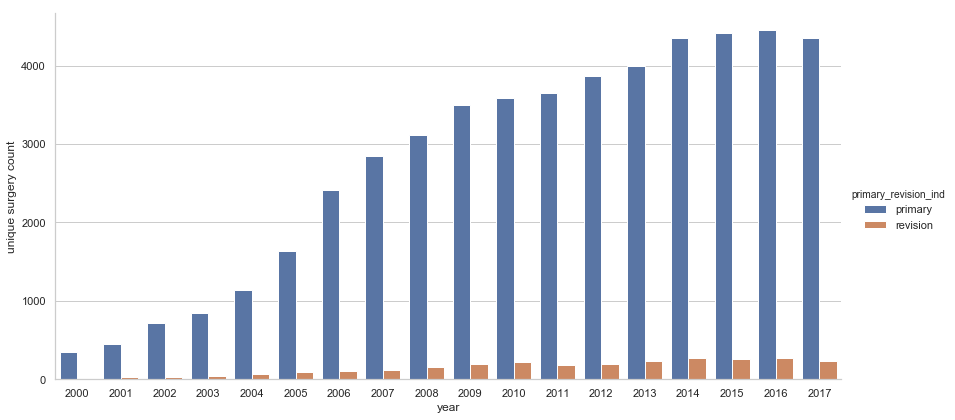

In [52]:
sns.set(style='whitegrid')
df_primary_revision = df_surgery_device_dtls[['PatientICN','SurgerySID','year','primary_revision_ind']]
df_primary_revision_final = df_primary_revision.groupby(['year','primary_revision_ind'])['SurgerySID'].nunique()
df_primary_revision_final = df_primary_revision_final.reset_index(drop=False)
df_primary_revision_final.rename({'SurgerySID':'unique surgery count'}, axis=1, inplace=True)

g = sns.catplot(x='year', y='unique surgery count', hue='primary_revision_ind', data=df_primary_revision_final, 
                kind='bar', hue_order=['primary','revision'], legend=True, height=6, aspect=2)
plt.show()

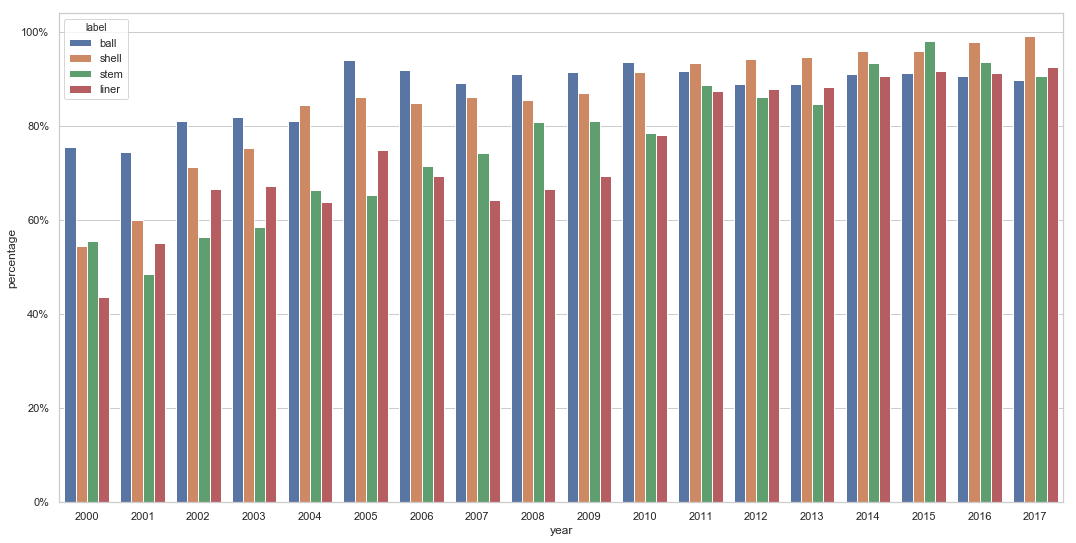

In [53]:
df_test = df_surgery_device_dtls[(df_surgery_device_dtls['gmdnPTName'].notnull()) &
                                 (df_surgery_device_dtls['primary_revision_ind'] == 'primary')]
df_test_pivot = df_test.groupby(['year'])['SurgerySID'].nunique()
df_test_pivot = df_test_pivot.reset_index(drop=False)
df_surgery_count = df_test_pivot
df_surgery_count.rename({'SurgerySID':'count'}, axis='columns', inplace=True)
df_surgery_count['label'] = '# THAs'

df_test = df_surgery_device_dtls[(df_surgery_device_dtls['device_type_label'].astype(str).str.contains('shell|liner|stem|ball', case=False)) &
                                 (df_surgery_device_dtls['primary_revision_ind'] == 'primary')]
df_test_pivot = df_test.groupby(['year','device_type_label'], as_index=False)['PatientICN'].count()
df_device_type = df_test_pivot
df_device_type.rename({'device_type_label':'label','PatientICN':'count'}, axis='columns', inplace=True)

df_figure_one = pd.merge(df_device_type, df_surgery_count, how='inner', on='year')
df_figure_one.drop(['label_y'], axis=1, inplace=True)
df_figure_one.rename({'label_x':'label','count_x':'numerator','count_y':'denominator'}, axis='columns', inplace=True)
df_figure_one.reset_index(drop=True, inplace=True)
df_figure_one.sort_values(['year'], ascending=True, inplace=True)
df_figure_one.reset_index(drop=True, inplace=True)
df_figure_one['percentage'] = df_figure_one['numerator'] / df_figure_one['denominator']

plt.figure(figsize=(18,9))
sns.set(style='whitegrid')
g = sns.barplot(x='year', y='percentage', hue='label', data=df_figure_one, hue_order=['ball','shell','stem','liner',]) 
g.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

<Figure size 1296x648 with 0 Axes>

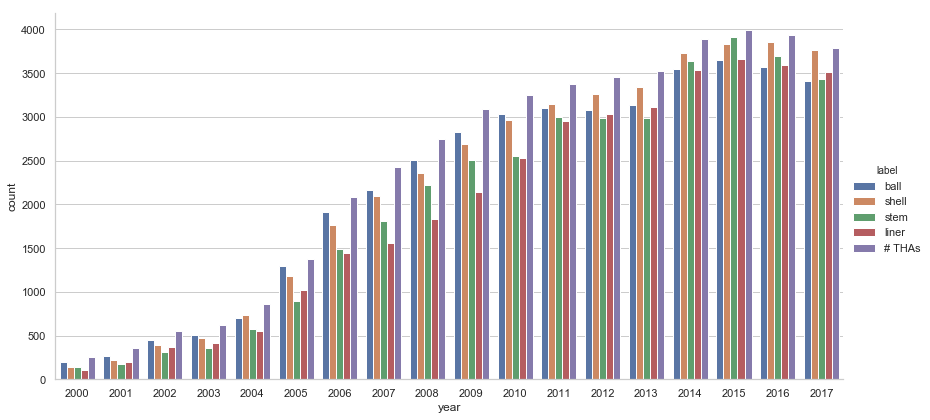

In [54]:
df_figure_one = pd.concat([df_device_type, df_surgery_count], axis=0, ignore_index=True, sort=False)
df_figure_one.reset_index(drop=True, inplace=True)
df_figure_one.sort_values(['year'], ascending=True, inplace=True)
df_figure_one.reset_index(drop=True, inplace=True)

plt.figure(figsize=(18,9))
sns.set(style='whitegrid')
g = sns.catplot(x='year', y='count', hue='label', data=df_figure_one, kind='bar', 
                hue_order=['ball','shell','stem','liner','# THAs'], legend=True, height=6, aspect=2)
plt.show()

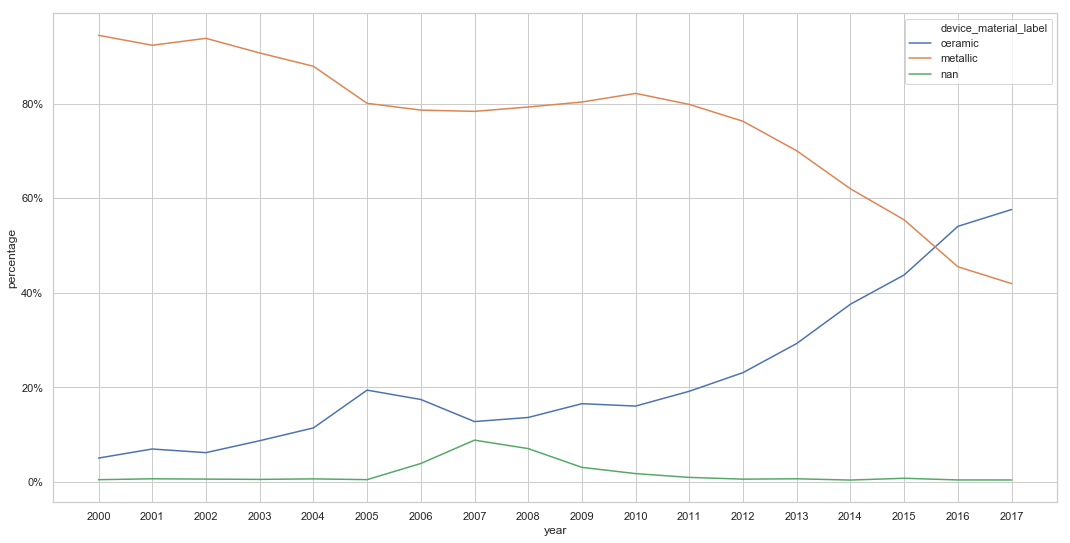

Wall time: 1.06 s


In [55]:
%%time

df_test = df_surgery_device_dtls[df_surgery_device_dtls['device_type_label'] == 'ball']
df_test_pivot = df_test.groupby(['year','device_material_label'], as_index=False)['PatientICN'].count()
df_test_pivot.rename({'PatientICN':'count'}, axis='columns', inplace=True)
df_test_pivot['year'] = df_test_pivot['year'].astype(str)
df_test_pivot['yearly_total'] = df_test_pivot.groupby('year')['count'].transform('sum')
df_test_pivot['percentage'] = df_test_pivot['count'] / df_test_pivot['yearly_total']
df_ball_mat = df_test_pivot

plt.figure(figsize=(18,9))
sns.set(style='whitegrid')
g = sns.lineplot(x='year', y='percentage', hue='device_material_label', data=df_ball_mat)
g.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [56]:
%%time

df_tha_surg = df_surgery_device_dtls[(df_surgery_device_dtls['device_type_label'].astype(str).str.contains('stem|shell|ball|liner', case=False, na=False))]

df_tha_surg = df_tha_surg[(df_tha_surg['duration'] > 0) &
                          (df_tha_surg['duration'] < 19)]

funcs = {'failed_part_ind':'max',
         'duration':'min',
         'year_bins':'min'}

df_revised_surgeries = df_tha_surg.groupby(['SurgerySID'], as_index=False).agg(funcs)
df_revised_surgeries.reset_index(drop=True, inplace=True)

Wall time: 14.6 s


To estimate the survival function, we will utilize the Kaplan-Meier Estimate defined as:

$\hat{S}(t) = \prod_{t_i \lt t} \frac{n_i - d_i}{n_i}$

where $d_i$ are the number of device failure events at time $t$ and $n_i$ is the number of prosthetic devices at risk of failure just prior to time $t$.

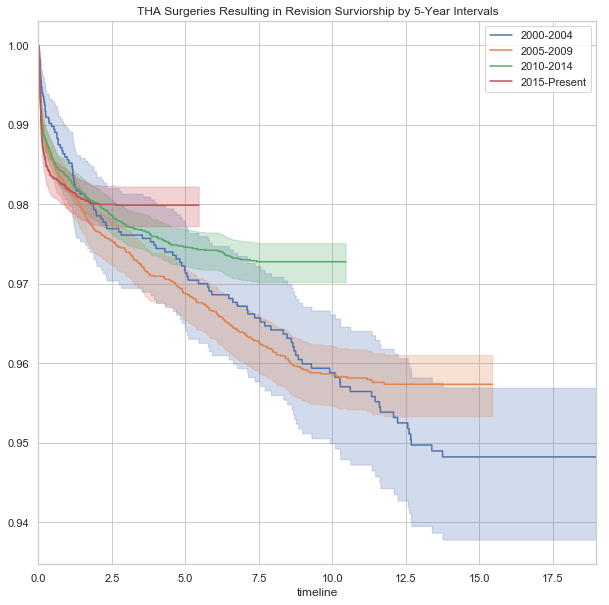

In [57]:
kmf = KaplanMeierFitter()

year_bin_list = ['2000-2004','2005-2009','2010-2014','2015-Present']

T = df_revised_surgeries['duration']
E = df_revised_surgeries['failed_part_ind']

plt.rcParams['figure.figsize'] = (10,10)
ax = plt.subplot(111)

for i, year_bin in enumerate(year_bin_list):
    ix = df_revised_surgeries['year_bins'] == year_bin
    kmf.fit(T[ix], E[ix], label=year_bin)
    kmf.plot(ax=ax)  
    
plt.title('THA Surgeries Resulting in Revision Surviorship by 5-Year Intervals')
plt.show()
plt.close()

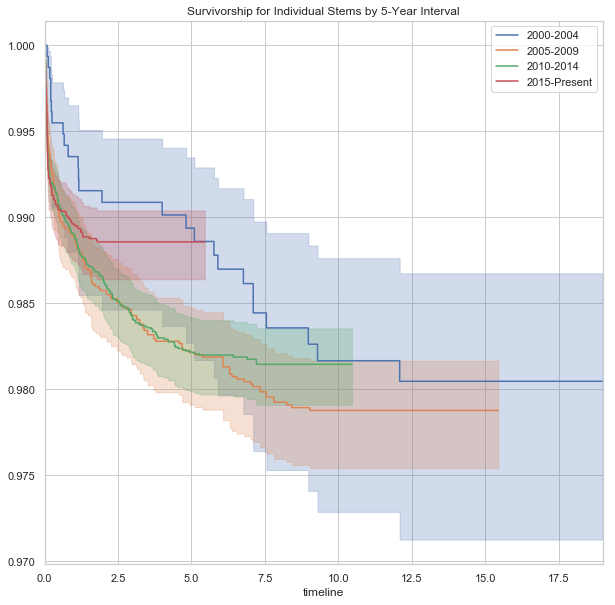

In [58]:
kmf = KaplanMeierFitter()

df_cross_flds = df_surgery_device_dtls[['PatientICN','SurgerySID','SurgeryDateTime','year','year_bins','prosthesis_combo_id',
                                        'prosthesis_combo_mini_id','device_type_label','primary_revision_ind','duration','failed_part_ind']]

df_cross_flds = df_cross_flds[(df_cross_flds['device_type_label'].astype(str).str.contains('stem', case=False, na=False)) & #shell
                              (df_cross_flds['primary_revision_ind'] == 'primary')] 

df_cross_flds = df_cross_flds[(df_cross_flds['duration'] > 0) &
                              (df_cross_flds['duration'] < 19)]

year_bin_list = ['2000-2004','2005-2009','2010-2014','2015-Present']

T = df_cross_flds['duration']
E = df_cross_flds['failed_part_ind']

plt.rcParams['figure.figsize'] = (10,10)
ax = plt.subplot(111)

for i, year_bin in enumerate(year_bin_list):
    ix = df_cross_flds['year_bins'] == year_bin
    kmf.fit(T[ix], E[ix], label=year_bin)
    kmf.plot(ax=ax)  
    
plt.title('Survivorship for Individual Stems by 5-Year Interval')
plt.show()
plt.close()

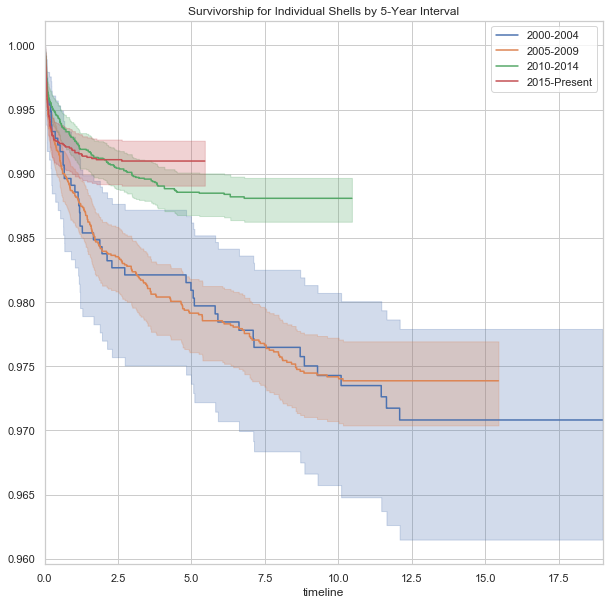

In [59]:
kmf = KaplanMeierFitter()

df_cross_flds = df_surgery_device_dtls[['PatientICN','SurgerySID','SurgeryDateTime','year','year_bins','prosthesis_combo_id',
                                        'prosthesis_combo_mini_id','device_type_label','primary_revision_ind','duration','failed_part_ind']]

df_cross_flds = df_cross_flds[(df_cross_flds['device_type_label'].astype(str).str.contains('shell', case=False, na=False)) & #stem
                              (df_cross_flds['primary_revision_ind'] == 'primary')] 

df_cross_flds = df_cross_flds[(df_cross_flds['duration'] > 0) &
                              (df_cross_flds['duration'] < 19)]

year_bin_list = ['2000-2004','2005-2009','2010-2014','2015-Present']

T = df_cross_flds['duration']
E = df_cross_flds['failed_part_ind']

plt.rcParams['figure.figsize'] = (10,10)
ax = plt.subplot(111)

for i, year_bin in enumerate(year_bin_list):
    ix = df_cross_flds['year_bins'] == year_bin
    kmf.fit(T[ix], E[ix], label=year_bin)
    kmf.plot(ax=ax)  
    
plt.title('Survivorship for Individual Shells by 5-Year Interval')
plt.show()
plt.close()

In [ ]:
%%time

# create a directory of individual kaplan-meier plot image files for stems with greater than 100 examples

df_stems = df_surgery_device_dtls[df_surgery_device_dtls['device_type_label'] == 'stem']
df_stems.reset_index(drop=True, inplace=False)
df_stem_count = df_stems.groupby(['prosthesis_combo_id'], as_index=False)['PatientICN'].count()
df_stem_count.rename({'PatientICN':'count'}, axis=1, inplace=True)
df_top_stems = df_stem_count[(df_stem_count['count'] > 100) |
                             (df_stem_count['prosthesis_combo_id'].astype(str).str.contains('asr', case=False))]
df_top_stems.reset_index(drop=True, inplace=False)

target_stem_list = df_top_stems['prosthesis_combo_id'].unique()

T = df_surgery_device_dtls['duration']
E = df_surgery_device_dtls['failed_part_ind']

for i, part_type in enumerate(target_stem_list):
    
    fig = plt.figure(figsize=(14,7))
    ax = plt.subplot(111)
    #ax.xaxis.set_visible(False)
    ax.set_xlim(0,20)
    
    kmf_indiv_stems = KaplanMeierFitter()
    kmf_indiv_ix = df_surgery_device_dtls['prosthesis_combo_id'] == part_type
    kmf_indiv_stems.fit(T[kmf_indiv_ix], E[kmf_indiv_ix], label=part_type)
    kmf_indiv_stems.plot(legend=True, ax=ax) 
    plt.title(part_type)
    
    kmf_all_stems = KaplanMeierFitter()
    kmf_all_ix = df_surgery_device_dtls['device_type_label'] == 'stem'
    kmf_all_stems.fit(T[kmf_all_ix], E[kmf_all_ix], label='all stems: 2000-present')
    kmf_all_stems.plot(legend=True, ax=ax)
    
    add_at_risk_counts(kmf_indiv_stems, kmf_all_stems, ax=ax, fig=fig, labels=None)
    
    plt.ylabel('Fraction in use after $n$ years')
    plt.savefig('PATH/stem_{}.png'.format(i + 1), dpi=fig.dpi, bbox_inches='tight')
    plt.close()

In [ ]:
%%time

# create a directory of individual kaplan-meier plot image files for shells with greater than 100 examples

df_shells = df_surgery_device_dtls[df_surgery_device_dtls['device_type_label'] == 'shell']
df_shells.reset_index(drop=True, inplace=False)
df_shell_count = df_shells.groupby(['prosthesis_combo_id'], as_index=False)['PatientICN'].count()
df_shell_count.rename({'PatientICN':'count'}, axis=1, inplace=True)
df_top_shells = df_shell_count[(df_shell_count['count'] > 100) |
                               (df_shell_count['prosthesis_combo_id'].astype(str).str.contains('asr', case=False))]
df_top_shells.reset_index(drop=True, inplace=False)

target_shell_list = df_top_shells['prosthesis_combo_id'].unique()

T = df_surgery_device_dtls['duration']
E = df_surgery_device_dtls['failed_part_ind']

for i, part_type in enumerate(target_shell_list):
    
    fig = plt.figure(figsize=(14,7))
    ax = plt.subplot(111)
    #ax.xaxis.set_visible(False)
    ax.set_xlim(0,20)
    
    kmf_indiv_shells = KaplanMeierFitter()
    kmf_indiv_ix = df_surgery_device_dtls['prosthesis_combo_id'] == part_type
    kmf_indiv_shells.fit(T[kmf_indiv_ix], E[kmf_indiv_ix], label=part_type)
    kmf_indiv_shells.plot(legend=True, ax=ax) 
    plt.title(part_type)
    
    kmf_all_shells = KaplanMeierFitter()
    kmf_all_ix = df_surgery_device_dtls['device_type_label'] == 'shell'
    kmf_all_shells.fit(T[kmf_all_ix], E[kmf_all_ix], label='all shells: 2000-present')
    kmf_all_shells.plot(legend=True, ax=ax)
    
    add_at_risk_counts(kmf_indiv_shells, kmf_all_shells, ax=ax, labels=None)
    
    plt.ylabel('Fraction in use after $n$ years')
    plt.savefig('PATH/shell_{}.png'.format(i + 1), dpi=fig.dpi, bbox_inches='tight')
    plt.close()